# Read and clean data

In [139]:
from helpers import make_aesthetic, array_stats, categorical_stats, pymer2latex


# NOTE: To use pymer, which is calling R, you have to have R and the needed packages (eg lmer packages, lmertest) installed.  
from pymer4.models import Lmer

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from stargazer.stargazer import Stargazer

mypal = make_aesthetic()


def clean_shallow_deep(x):
    # because scale is -2, -1, 0, 1, 2 and qualtrics is 1, 2, 3, 4, 5
    # So this function turns metric into -2 to 2 in direction of <deep --> shallow> 

    if pd.isna(x):
        return None 
    return (int(x) - 3) * -1

def clean_general(x):
    # Take first character
    # This is 1-5
    if pd.isna(x):
        return None
    return int(x[0])

def clean_even(x):
    # qualtrics is coding as 1, 2, 3, 4, 5
    # semantic scale was # (normalize to -2, -1, 0, 1, 2)
    # where 0 meant both equal. 
    # So we want to penalize large deviations from 0 
    # recode from 1 to 3
    if pd.isna(x):
        return None
    x2 = int(x) - 3 # (normalize to -2, -1, 0, 1, 2)
    if x2 in [-2, 2]:
        return 1
    elif x2 in [-1, 1]:
        return 2
    elif x2 == 0:
        return 3

df1 = pd.read_csv('data/raw/deep_shallow_w_prima.csv')
df1 = df1.iloc[2:]
df1['value_set'] = "prima_facie"

df2 = pd.read_csv('data/raw/deep_shallow_w_schwartz.csv')
df2 = df2.iloc[2:]
df2['value_set'] = "schwartz"

df = pd.concat([df1, df2], axis=0)


data = []
for idx, row in df.iterrows():
    
    # participant data
    duration = row['Duration (in seconds)']
    pid = row['pid']
    deep_shallow_1 = row['deep_shallow_1']
    deep_shallow_2 = row['deep_shallow_2']
    educ = row['educ']
    income = row['income']
    gender = row['gender']
    age = row['Age']
    ai_usage = row['ai_usage']
    con = row['con']
    
    participant_data = {
        "duration": duration,
        "pid": pid,
        "deep_shallow_1": deep_shallow_1,
        "deep_shallow_2": deep_shallow_2,
        "educ": educ,
        "income": income,
        "gender": gender, 
        "age": age,
        "ai_usage": ai_usage,
        "con": con
    }
    
    llm_shallow_cols = [x for x in df.columns if "lm_shallow_" in x]
    for col in llm_shallow_cols:
        data_pt = {
            "raw_col": col,
            "metric": "deep_shallow",
            "loop_merge": int(col.split("_")[0]),
            "answer_raw": row[col],
            "answer": clean_shallow_deep(row[col]),
        }
        data_pt.update(participant_data)
        data.append(data_pt)
        
    llm_general_cols = [x for x in df.columns if "lm_general" in x]
    for col in llm_general_cols:
        data_pt = {
            "raw_col": col,
            "metric": "general",
            "loop_merge": int(col.split("_")[0]),
            "answer_raw": row[col],
            "answer": clean_general(row[col]),
        }

        data_pt.update(participant_data)
        data.append(data_pt)
    llm_split_cols = [x for x in df.columns if "lm_split" in x]
    for col in llm_split_cols:
        data_pt = {
            "raw_col": col,
            "metric": "even",
            "loop_merge": int(col.split("_")[0]),
            "answer_raw": row[col],
            "answer": clean_even(row[col]),
        }
        data_pt.update(participant_data)
        data.append(data_pt)
    
    
df = pd.DataFrame(data)
df = df.dropna(subset=['answer'])

meta_df = pd.read_csv('data/clean/qualtrics_loop_merge_deep_shallow.csv')
df = pd.merge(df, meta_df, how='left', left_on=['loop_merge'], right_on=['idx'])
df['original_name'] = df['name']
df['name'] = df['name'] + ": " + df['name1'] + "/" + df['name2']


    
dfs = {}
dfs['deep_shallow'] = df[df['metric'] == 'deep_shallow']
dfs['general'] = df[df['metric'] == 'general']
dfs['even'] = df[df['metric'] == 'even']


df['deep_shallow_1_correct'] = df['deep_shallow_1'].apply(
    lambda x: 1 if pd.notna(x) and "while deep values are what people want to want" in x else 0
)
df['deep_shallow_2_correct'] = df['deep_shallow_2'].apply(
    lambda x: 1 if pd.notna(x) and "Wanting to be the kind of person who stands up for justice" in x else 0
)
df['deep_shallow_correct_sum'] = df['deep_shallow_1_correct'] + df['deep_shallow_2_correct']
deep_df = df[df['metric'] == "deep_shallow"]
by_person = deep_df.drop_duplicates(subset=['pid'])
print(by_person['deep_shallow_correct_sum'].value_counts(normalize=False))
print(by_person['deep_shallow_correct_sum'].value_counts(normalize=True))

not_all_correct = by_person.query("deep_shallow_correct_sum <2")['pid'].to_list()
dfna = df.query("pid not in @not_all_correct")


    

deep_shallow_correct_sum
2    25
1     3
Name: count, dtype: int64
deep_shallow_correct_sum
2    0.892857
1    0.107143
Name: proportion, dtype: float64


# Shallowness: Preferences vs values 

## Plot and descriptives

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_22964/736208484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['deep_shallow']['clean_set'] = dfs['deep_shallow']['set'].replace({'shallow': 'Shallow\nPreferences', 'deep': 'Deep\nValues'})
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_22964/736208484.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=dfs['deep_shallow'], x='clean_set', y='answer', palette=mypal)
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_22964/736208484.py:2: UserWarning: The palette list has more values (15) than needed (2), w

Deep value stats
M = -0.98, SD = 1.00, Mdn = -1.00
Mode = -1.00
95% CI [-1.13, -0.83]
Shallow preference stats
M = 0.34, SD = 1.36, Mdn = 1.00
Mode = 1.00
95% CI [0.21, 0.48]
cohens d 1.049187902220973
cles 0.766840365071384
t(558) = -12.83, p < .001


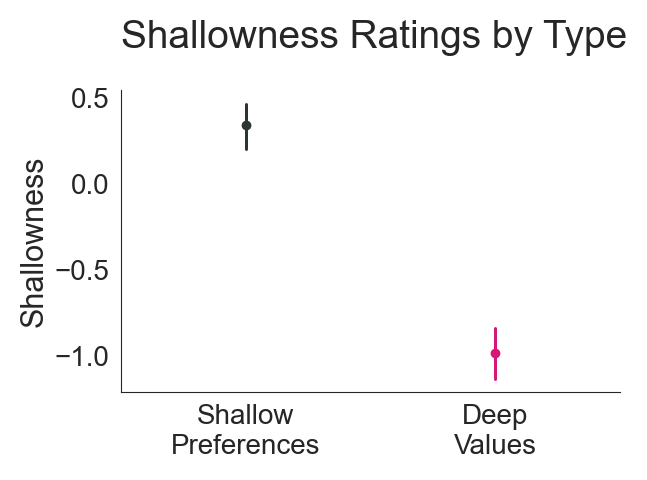

In [134]:
dfs['deep_shallow']['clean_set'] = dfs['deep_shallow']['set'].replace({'shallow': 'Shallow\nPreferences', 'deep': 'Deep\nValues'})
sns.pointplot(data=dfs['deep_shallow'], x='clean_set', y='answer', palette=mypal)

plt.title("Shallowness Ratings by Type")
plt.xlabel("")
plt.ylabel("Shallowness")

deep_value_ratings = dfs['deep_shallow'].query('set == "deep"')['answer'].values
shallow_pref_ratings = dfs['deep_shallow'].query('set == "shallow"')['answer'].values

print("Deep value stats")
array_stats(deep_value_ratings, include_ci=True)

print("Shallow preference stats")
array_stats(shallow_pref_ratings, include_ci=True)

from pingouin import compute_effsize

print("cohens d", compute_effsize(shallow_pref_ratings, deep_value_ratings, paired=False, eftype='cohen'))
print("cles", compute_effsize(shallow_pref_ratings, deep_value_ratings, paired=False, eftype='cles'))

# ttest
from scipy import stats
t_stat, p_val = stats.ttest_ind(deep_value_ratings, shallow_pref_ratings, equal_var=False)
dof = len(deep_value_ratings) + len(shallow_pref_ratings) - 2


p_formatted = "< .001" if p_val < 0.001 else f"= {p_val:.3f}"

print(f"t({dof:.0f}) = {t_stat:.2f}, p {p_formatted}")



## Can people tell the difference?

### Desc metrics


Classification Report (Filtered):
              precision    recall  f1-score   support

        Deep      0.498     0.898     0.641       137
     Shallow      0.936     0.624     0.749       330

    accuracy                          0.704       467
   macro avg      0.717     0.761     0.695       467
weighted avg      0.808     0.704     0.717       467


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_22964/546536034.py:41: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=dfs['deep_shallow'], x='clean_set', y='answer',


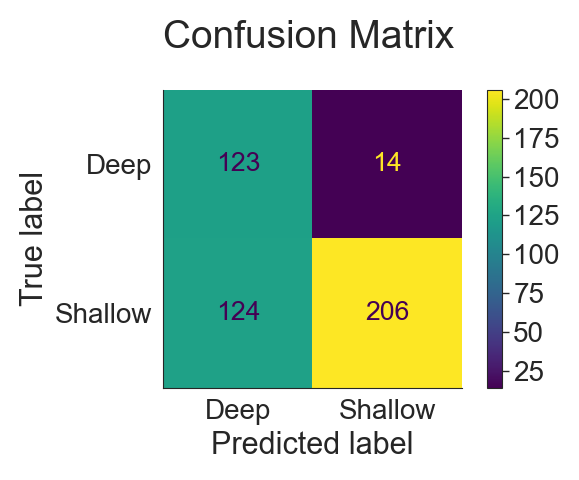

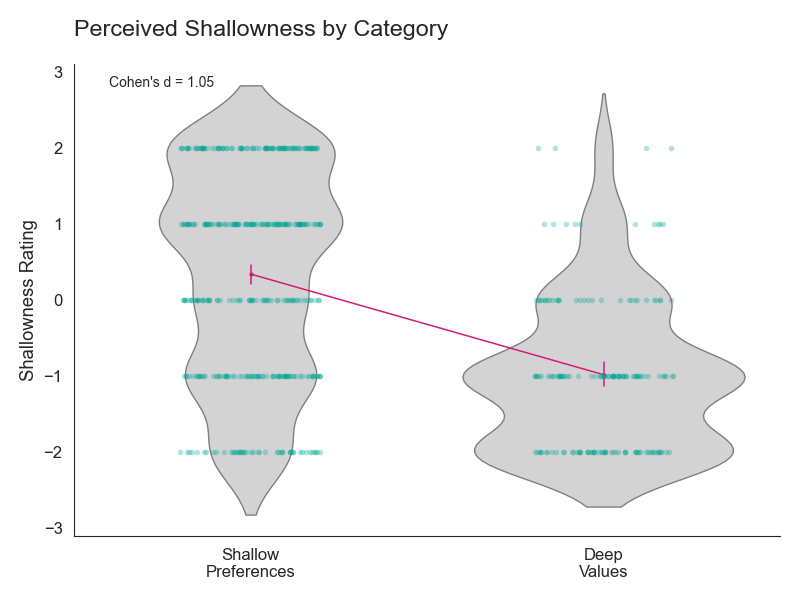

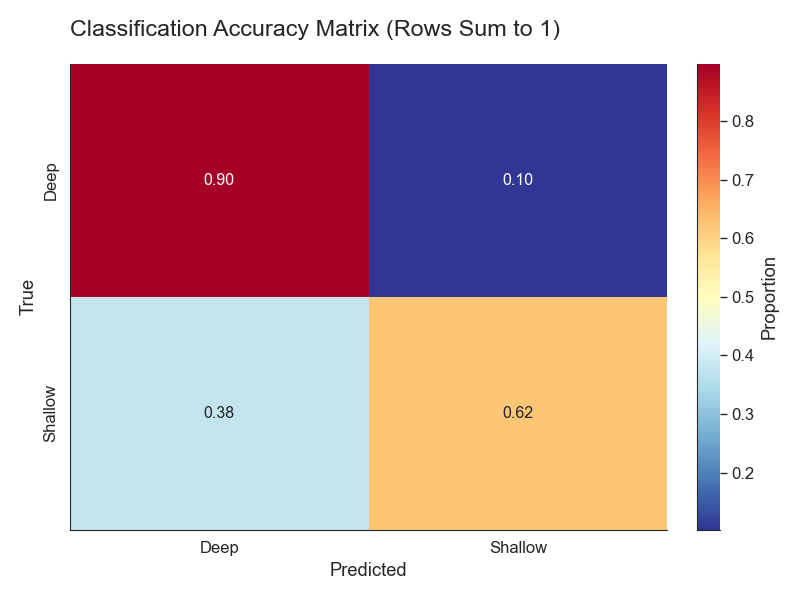

In [135]:
# Basic calcs
############################
############################

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

shallow_deep = dfs['deep_shallow'].copy()
filtered_shallow_deep = shallow_deep[shallow_deep['answer'] != 0]

# Update y_true and y_pred based on the filtered data
y_true = (filtered_shallow_deep['set'] == 'shallow').astype(int)
y_pred = (filtered_shallow_deep['answer'] > 0).astype(int)

# Compute confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Deep', 'Shallow'])
cmd.plot()
plt.title('Confusion Matrix')
plt.savefig('plots/confusion_matrix_filtered.pdf', bbox_inches='tight', dpi=300)

print("\nClassification Report (Filtered):")
print(classification_report(y_true, y_pred, 
                            target_names=['Deep', 'Shallow'],
                            digits=3))




# More plots
############################
############################
# First Plot: Perceived Shallowness by Category
plt.figure(figsize=(8, 6))
make_aesthetic(font_scale=1.2)

sns.violinplot(data=dfs['deep_shallow'], x='clean_set', y='answer',
               inner=None, color='lightgray')
sns.stripplot(data=dfs['deep_shallow'], x='clean_set', y='answer',
              size=4, alpha=0.3, jitter=0.2, color=mypal[2])
sns.pointplot(data=dfs['deep_shallow'], x='clean_set', y='answer',
              scale=0.5, color=mypal[1])

cohens_d = compute_effsize(shallow_pref_ratings, deep_value_ratings, paired=False, eftype='cohen')
plt.text(0.05, 0.95, f"Cohen's d = {cohens_d:.2f}",
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
         fontsize=10)

plt.title('Perceived Shallowness by Category', pad=20)
plt.xlabel('')
plt.ylabel('Shallowness Rating')
plt.savefig('plots/violin_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Second Plot: Classification Accuracy Matrix
plt.figure(figsize=(8, 6))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=True, fmt='.2f',
            cmap='RdYlBu_r',
            xticklabels=['Deep', 'Shallow'],
            yticklabels=['Deep', 'Shallow'])

cbar = plt.gca().collections[0].colorbar
cbar.set_label('Proportion')

plt.title('Classification Accuracy Matrix (Rows Sum to 1)', pad=20)
plt.xlabel('Predicted')
plt.ylabel('True')
sns.despine()
plt.savefig('plots/confusion_matrix_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()


### Mixed model

In [136]:


# Run model
##############
##############

tdf = dfs['deep_shallow']
tdf['group'] = 1
tdf['z_answer'] = (tdf['answer'] - tdf['answer'].mean()) / tdf['answer'].std()


# NOTE: To use pymer you will have to have R and needed packages
selected_columns = ['z_answer', 'name', 'pid', 'set']
tdf = tdf[selected_columns]
model = Lmer('z_answer ~ set + (1|pid) + (1|name)', data=tdf)
result = model.fit()


model_var_comp = Lmer('z_answer ~ (1|pid) + (1|name)', data=tdf)
result_var_comp = model_var_comp.fit()

print(result)

result_s = model.coefs.reset_index().query("index=='setshallow'")[['Estimate', 'SE', 'T-stat', 'P-val']].apply(
    lambda x: f"Beta={x['Estimate']:.2f}, (SE={x['SE']:.2f}, t={x['T-stat']:.2f}, p={float(x['P-val']):.1e}), N={len(tdf)}", axis=1
).values[0]


latex_str = pymer2latex(model, caption="Mixed model results from shallow/deep annotation. The DV is z-scored shallowness. The baseline condition is is deep values. The fixed effect can be interpreted as the difference in shallowness for shallow preferences versus deep values, for a typical participant and item.", label="mixed_model_shallow_deep")
latex_str  = latex_str.replace("setshallow", "IsShallow").replace("z_answer", "Z-Scored Shallowness").replace("pid", "Person").replace("name", "Item")

print(latex_str)

with open('tables/mixed_model_shallow_deep.tex', 'w') as f:
    f.write(latex_str)





/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_22964/792678080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['group'] = 1
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_22964/792678080.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['z_answer'] = (tdf['answer'] - tdf['answer'].mean()) / tdf['answer'].std()
/Users/joshash/locresearch/LocResearch/dvb_wrapper/dvb/.venv_fix/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has bee

Linear mixed model fit by REML [’lmerMod’]
Formula: z_answer~set+(1|pid)+(1|name)

Family: gaussian	 Inference: parametric

Number of observations: 560	 Groups: {'name': 57.0, 'pid': 28.0}

Log-likelihood: -722.036 	 AIC: 1454.073

Random effects:

                 Name    Var    Std
name      (Intercept)  0.093  0.305
pid       (Intercept)  0.057  0.238
Residual               0.671  0.819

No random effect correlations specified

Fixed effects:
Linear mixed model fit by REML [’lmerMod’]
Formula: z_answer~(1|pid)+(1|name)

Family: gaussian	 Inference: parametric

Number of observations: 560	 Groups: {'name': 57.0, 'pid': 28.0}

Log-likelihood: -742.632 	 AIC: 1493.263

Random effects:

                 Name    Var    Std
name      (Intercept)  0.277  0.526
pid       (Intercept)  0.061  0.248
Residual               0.671  0.819

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    -0.652  -0.857

/Users/joshash/locresearch/LocResearch/dvb_wrapper/dvb/.venv_fix/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


#### Variance component analysis

In [112]:
item_var_conf = model.confint(method="profile", parm=["sd_(Intercept)|name"])
person_var_conf = model.confint(method="profile", parm=["sd_(Intercept)|pid"])

var_comp = {}
var_comp['item_var'] = {
    "sd_low":item_var_conf["2.5 %"].values[0], 
    "sd_high": item_var_conf["97.5 %"].values[0],
    "sd_point": model.ranef_var.reset_index().query("index == 'name'")['Std'].values[0],
    "var_low": item_var_conf["2.5 %"].values[0]**2,
    "var_high": item_var_conf["97.5 %"].values[0]**2,
    "var_point": model.ranef_var.reset_index().query("index == 'name'")['Var'].values[0],
}

var_comp['person_var'] = {
    "sd_low":person_var_conf["2.5 %"].values[0],
    "sd_high": person_var_conf["97.5 %"].values[0],
    "sd_point": model.ranef_var.reset_index().query("index == 'pid'")['Std'].values[0],
    "var_low": person_var_conf["2.5 %"].values[0]**2, 
    "var_high": person_var_conf["97.5 %"].values[0]**2,
    "var_point": model.ranef_var.reset_index().query("index == 'pid'")['Var'].values[0],
}

var_comp['unexplained'] = {
    "sd_low": None,
    "sd_high": None,
    "sd_point": model.ranef_var.reset_index().query("index == 'Residual'")['Std'].values[0],
    "var_low": None,
    "var_high": None,
    "var_point": model.ranef_var.reset_index().query("index == 'Residual'")['Var'].values[0],
}

var_comp_df = pd.DataFrame(var_comp).T

var_comp_df



Computing profile confidence intervals ...
Computing profile confidence intervals ...


,sd_low,sd_high,sd_point,var_low,var_high,var_point
item_var,0.203541,0.405750,0.304553,0.041429,0.164633,0.092752
person_var,0.140819,0.351395,0.237975,0.019830,0.123478,0.056632
unexplained,NaN,NaN,0.818980,NaN,NaN,0.670729


# Plot by index

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_22964/2391613055.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


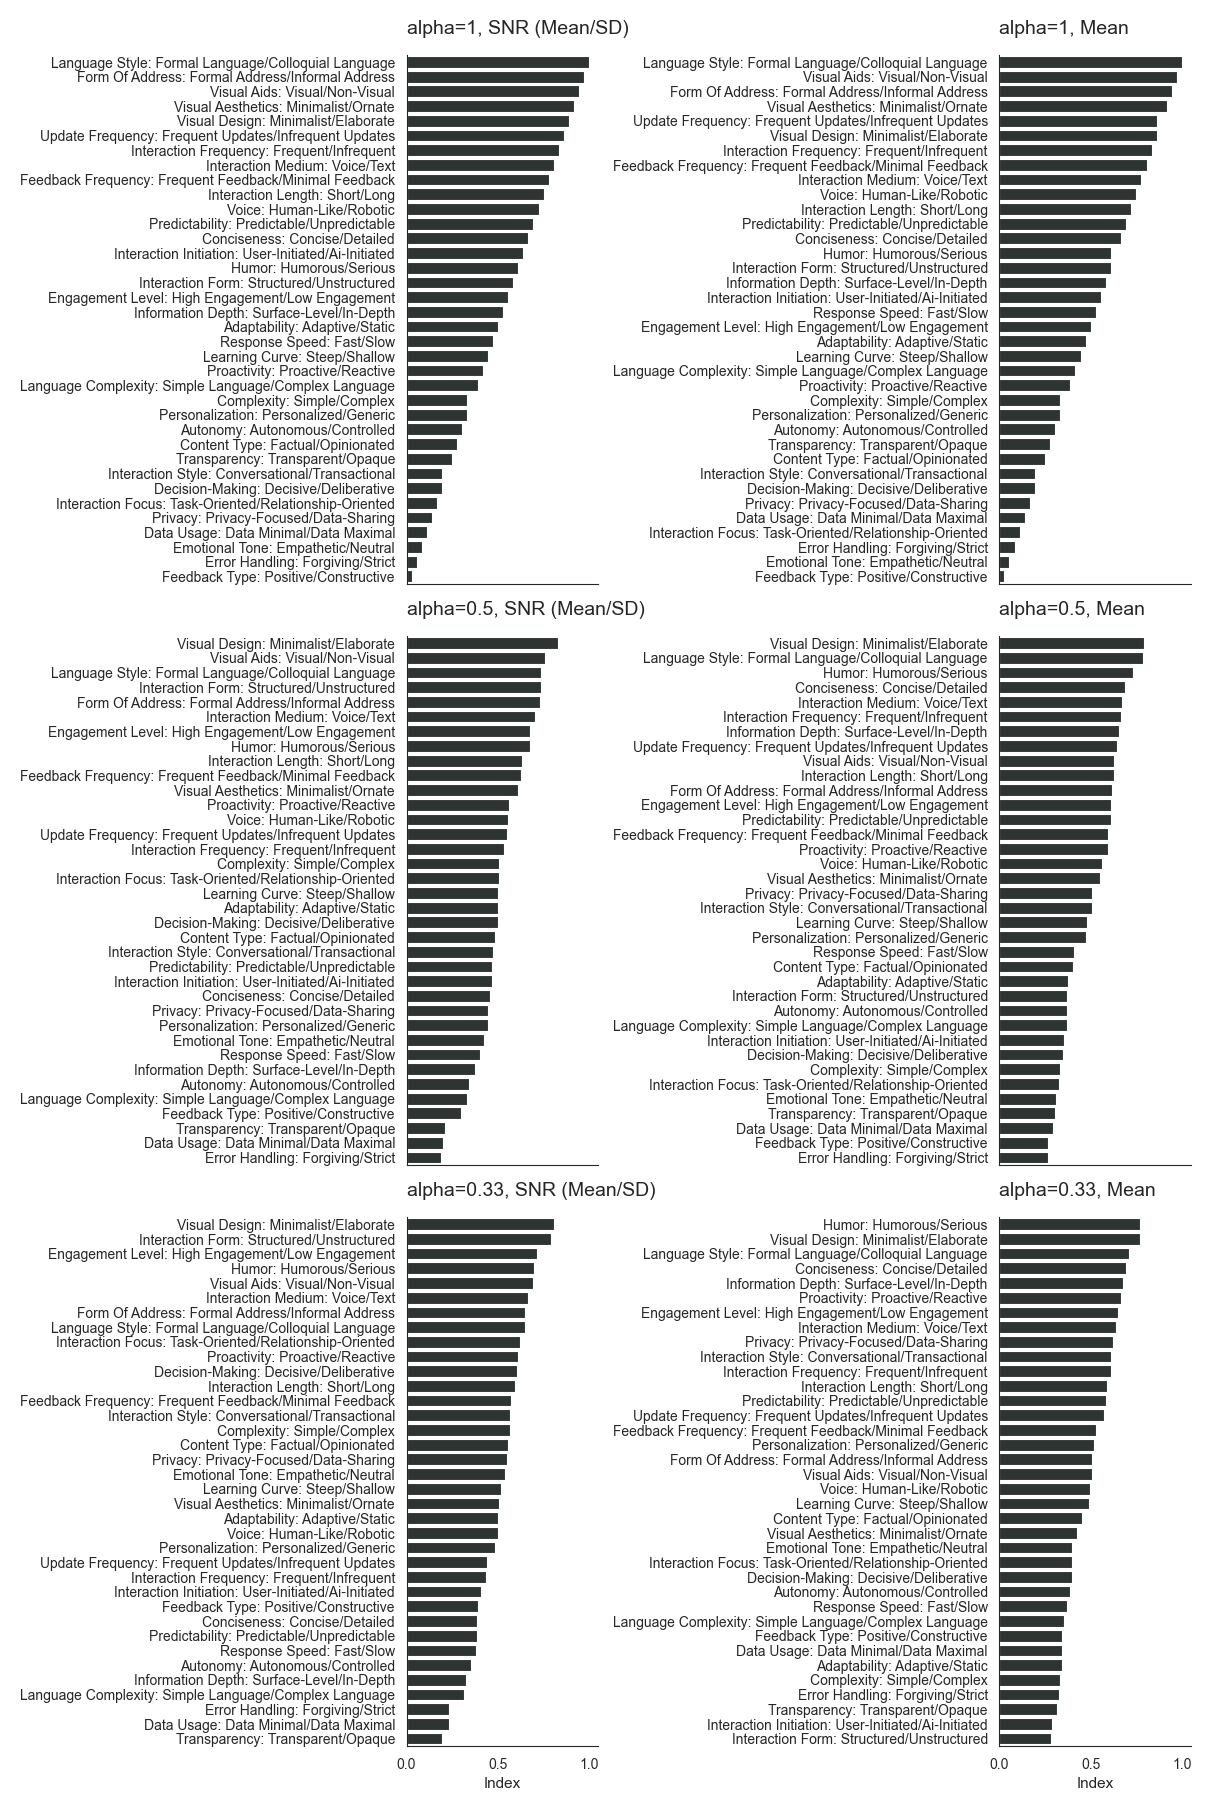

In [113]:

# Get data
########################
########################
shallow = df.query("set == 'shallow'")



d = shallow.query("metric == 'deep_shallow'").groupby('name').agg({'answer': ['mean', 'std']}).dropna()
d.columns = ['mean_deep_shallow', 'std_deep_shallow']
d['snr_deep_shallow'] = d['mean_deep_shallow'] / (d['std_deep_shallow']+0.001)

d2 = shallow.query("metric == 'general'").groupby('name').agg({'answer': ['mean', 'std']}).dropna()
d2.columns = ['mean_general', 'std_general']
d2['snr_general'] = d2['mean_general'] / (d2['std_general'] + 0.001)

d3 = shallow.query("metric == 'even'").groupby('name').agg({'answer': ['mean', 'std']}).dropna()
d3.columns = ['mean_even', 'std_even']
d3['snr_even'] = d3['mean_even'] / (d3['std_even'] + 0.001)

d = pd.concat([d, d2, d3], axis=1)
d.dropna(subset=['snr_deep_shallow', 'snr_general', 'snr_even'], inplace=True)




# Plot
# Logic: alpha*Rank(deep_shallow) + (1-alpha)/2* Rank(general) + (1-alpha)/2 * Rank(even)
# Optional: Use SNR or mean
########################
########################
make_aesthetic(font_scale=1)
alphas = [1, 0.5, 0.33]
use_snr_values = [True, False]

fig, axes = plt.subplots(len(alphas), len(use_snr_values), figsize=(12, 18), sharex=True, sharey=False)

for i, alpha in enumerate(alphas):
    for j, use_snr in enumerate(use_snr_values):
        plt.sca(axes[i, j])  
        if not use_snr:
            rel_cols = ['mean_deep_shallow', 'mean_general', 'mean_even']
        else:
            rel_cols = ['snr_deep_shallow', 'snr_general', 'snr_even']

        for col in rel_cols:
            # assigns a percentile rank where 1 means highest thing
            d[col] = d[col].rank(ascending=True, method='min', pct=True)

        other_alphas = (1 - alpha) / 2
        d['indx'] = alpha * d[rel_cols[0]] + other_alphas * d[rel_cols[1]] + other_alphas * d[rel_cols[2]]

        # Sort data for the current subplot
        d_sorted = d.sort_values('indx', ascending=False)

        # Get top and bottom items
        top = d_sorted.nlargest(50, 'indx')
        bottom = d_sorted.nsmallest(50, 'indx')
        extreme = pd.concat([top, bottom])
        
        make_aesthetic(font_scale=1)
        sns.barplot(data=extreme, y='name', x='indx', ax=axes[i, j])
        axes[i, j].set_title(f"alpha={alpha}, {'SNR (Mean/SD)' if use_snr else 'Mean'}")
        axes[i, j].set_xlabel("Index")
        axes[i, j].set_ylabel("")

plt.tight_layout()
plt.savefig('plots/index_plot_new_x_axis.pdf', bbox_inches='tight', dpi=300)
plt.show()


## General desc stats

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_22964/3371295560.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


M = 3.32, SD = 1.17, Mdn = 3.00
Mode = 3.00


{'mean': np.float64(3.32),
 'median': np.float64(3.0),
 'sd': np.float64(1.17),
 'mode': np.float64(3.0)}

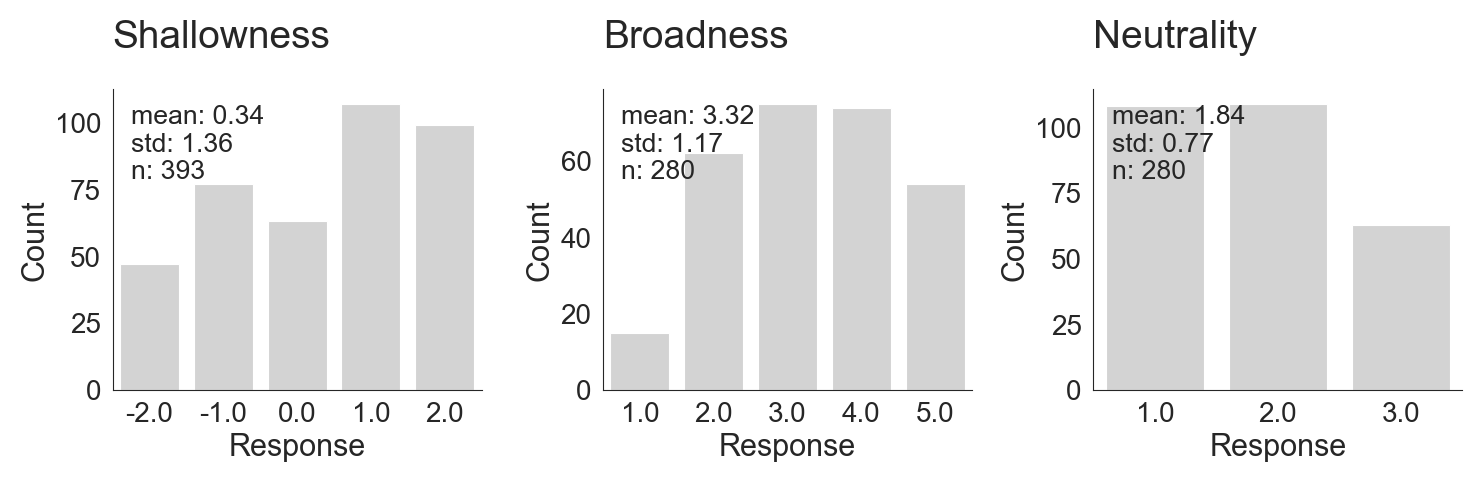

In [30]:
make_aesthetic(font_scale=2)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df['pretty_metric'] = df['metric'].replace({
    'deep_shallow': 'Shallowness',
    'general': 'Broadness',
    'even': 'Neutrality'})
metrics = df['pretty_metric'].unique()

shallow = df.query("set == 'shallow'")

for i, metric in enumerate(metrics):
    metric_data = shallow[shallow['pretty_metric'] == metric]
    
    value_counts = metric_data['answer'].value_counts().sort_index()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i], color='lightgray')
    
    stats = metric_data['answer'].describe()
    stats_text = f"mean: {stats['mean']:.2f}\nstd: {stats['std']:.2f}\nn: {stats['count']:.0f}"
    axes[i].text(0.05, 0.95, stats_text, transform=axes[i].transAxes,
                verticalalignment='top')
    
    axes[i].set_title(metric)
    axes[i].set_xlabel('Response')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.savefig('plots/general_desc_stats.pdf', bbox_inches='tight', dpi=300)

categorical_stats(df.query("metric == 'even'")['answer'], sort_by='alphabetical')

array_stats(df.query("metric == 'general'")['answer'])



# Case based indexing

## Set up data

In [31]:
shallow = df.query("set == 'shallow'")

shallow2 = shallow.groupby(['metric', 'name'])['answer'].agg(
    mean='mean',
    std='std',
    se = 'sem',
    count='count', 
    min = 'min',
).reset_index()

shallow2['lower_bound'] = shallow2['mean'] - 1.96*shallow2['se']

print("Number of ratings stats")
array_stats(shallow2['count'])


shallow_wide = shallow2.pivot(index='name', columns='metric', values=['mean', 'std', 'se', 'count', 'min', 'lower_bound'])

shallow_wide.columns = ['_'.join(col).strip() for col in shallow_wide.columns]
shallow_wide = shallow_wide.reset_index()


Number of ratings stats
M = 8.82, SD = 2.57, Mdn = 9.00
Mode = 7.00


## Case based: Past midpoint on everything

In [32]:
shallow_wide.query("mean_deep_shallow >0 & mean_general >= 3 & mean_even >= 2")['name'].to_list()


['Engagement Level: High Engagement/Low Engagement',
 'Humor: Humorous/Serious',
 'Information Depth: Surface-Level/In-Depth',
 'Interaction Frequency: Frequent/Infrequent',
 'Language Style: Formal Language/Colloquial Language',
 'Proactivity: Proactive/Reactive',
 'Visual Design: Minimalist/Elaborate']

## Case based: Past midpt for shallow deep then just take top 20 on an avg of other two

In [33]:
tdf = shallow_wide.query("mean_deep_shallow >0")
tdf['rank_neutral'] = tdf['mean_even'].rank(ascending=True) / len(tdf)
tdf['rank_general'] = tdf['mean_general'].rank(ascending=True) / len(tdf)
tdf['combined_rank'] = 0.5 * tdf['rank_general'] + 0.5 * tdf['rank_neutral']

print(tdf.sort_values('combined_rank', ascending=False).head(20)['name'].to_list())

['Proactivity: Proactive/Reactive', 'Humor: Humorous/Serious', 'Information Depth: Surface-Level/In-Depth', 'Engagement Level: High Engagement/Low Engagement', 'Conciseness: Concise/Detailed', 'Visual Design: Minimalist/Elaborate', 'Predictability: Predictable/Unpredictable', 'Learning Curve: Steep/Shallow', 'Interaction Length: Short/Long', 'Interaction Medium: Voice/Text', 'Language Style: Formal Language/Colloquial Language', 'Interaction Frequency: Frequent/Infrequent', 'Update Frequency: Frequent Updates/Infrequent Updates', 'Feedback Frequency: Frequent Feedback/Minimal Feedback', 'Voice: Human-Like/Robotic', 'Language Complexity: Simple Language/Complex Language', 'Adaptability: Adaptive/Static', 'Response Speed: Fast/Slow', 'Visual Aids: Visual/Non-Visual', 'Form Of Address: Formal Address/Informal Address']


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_22964/3288298273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['rank_neutral'] = tdf['mean_even'].rank(ascending=True) / len(tdf)
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_22964/3288298273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['rank_general'] = tdf['mean_general'].rank(ascending=True) / len(tdf)
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_22964/3288298273.py:4: SettingWithCopyWarning: 
A va

# Robustness Analysis: Different methods to pick stuff

In [137]:
def jaccard_similarity(set1, set2):
    """
    Calculate the Jaccard similarity between two sets.
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0



def make_shallow_wide(tdf):
    shallow = tdf.query("set == 'shallow'")

    shallow2 = shallow.groupby(['metric', 'name'])['answer'].agg(
        mean='mean',
        std='std',
        se = 'sem',
        count='count', 
        min = 'min',
    ).reset_index()
    
    shallow2['lower_bound'] = shallow2['mean'] - 1.96*shallow2['se']
        
    
    shallow_wide = shallow2.pivot(index='name', columns='metric', values=['mean', 'std', 'se', 'count', 'min', 'lower_bound'])
    shallow_wide.columns = ['_'.join(col).strip() for col in shallow_wide.columns]
    shallow_wide = shallow_wide.reset_index()
    return shallow_wide


def alpha_five_method(tdf):
    shallow_df = make_shallow_wide(tdf)
    shallow_df['rank_deep_shallow'] = shallow_df['mean_deep_shallow'].rank(ascending=True, method='min', pct=True) 
    shallow_df['rank_general'] = shallow_df['mean_general'].rank(ascending=True, method='min', pct=True)
    shallow_df['rank_even'] = shallow_df['mean_even'].rank(ascending=True, method='min', pct=True)
    shallow_df['alpha_five_score'] = 0.5 * shallow_df['rank_deep_shallow'] + 0.25 * shallow_df['rank_general'] + 0.25 * shallow_df['rank_even']
    alpha_five_set = shallow_df.sort_values('alpha_five_score', ascending=False).head(20)['name'].to_list()
    return alpha_five_set

def alpha_three_method(tdf):
    shallow_df = make_shallow_wide(tdf)
    shallow_df['rank_deep_shallow'] = shallow_df['mean_deep_shallow'].rank(ascending=True, method='min', pct=True) 
    shallow_df['rank_general'] = shallow_df['mean_general'].rank(ascending=True, method='min', pct=True)
    shallow_df['rank_even'] = shallow_df['mean_even'].rank(ascending=True, method='min', pct=True)
    # method 1.1, alpha=0.5
    shallow_df['alpha_three_score'] = 0.33 * shallow_df['rank_deep_shallow'] + 0.33 * shallow_df['rank_general'] + 0.33 * shallow_df['rank_even']
    alpha_three_set = shallow_df.sort_values('alpha_three_score', ascending=False).head(20)['name'].to_list()
    return alpha_three_set


def past_mid_method(tdf):
    shallow_df = make_shallow_wide(tdf)
    shallow_df['mean_past_mid'] = shallow_df['mean_deep_shallow'] > 0
    shallow_df['rank_general'] = shallow_df['mean_general'].rank(ascending=True, method='min', pct=True)
    shallow_df['rank_even'] = shallow_df['mean_even'].rank(ascending=True, method='min', pct=True)
    shallow_df['combined_rank'] = 0.5 * shallow_df['rank_general'] + 0.5 * shallow_df['rank_even']
    
    past_mid = shallow_df.query("mean_past_mid > 0").sort_values('combined_rank', ascending=False).head(20)['name'].to_list()
    return past_mid

# Get the sets
alpha_five_set = alpha_five_method(df)
alpha_three_set = alpha_three_method(df)
past_mid = past_mid_method(df)


set_names = {
    "alpha_five": alpha_five_set,
    "alpha_three": alpha_three_set,
    "past_mid": past_mid
}


for i, (name1, set1) in enumerate(set_names.items()):
    for j, (name2, set2) in enumerate(set_names.items()):
        if j > i:  # Ensure each pair is only compared once
            jaccard = jaccard_similarity(set(set1), set(set2))
            print(f"Jaccard similarity between {name1} and {name2}: {jaccard:.3f}")
            
            
for name1, set1 in set_names.items():
    print(f"{name1}: {len(set1)}")
    print(set1)
    
    
    

alpha_five_set2 = alpha_five_method(dfna)
alpha_three_set2 = alpha_three_method(dfna)
past_mid2 = past_mid_method(dfna)
    
    
# now compare jaccard for deleted 
set_names2 = {
    "alpha_five": alpha_five_set2,
    "alpha_three": alpha_three_set2,
    "past_mid": past_mid2
}

for name in set_names.keys():
    set_full = set(set_names[name])
    set_deleted = set(set_names2[name])
    jaccard = jaccard_similarity(set_full, set_deleted)
    print(f"Jaccard similarity between full and deleted for {name}: {jaccard:.3f}")
    
####### FINAL DECISION: PAST_MIDPOINT

past_mid_df = df.query("name in @past_mid")


Jaccard similarity between alpha_five and alpha_three: 0.905
Jaccard similarity between alpha_five and past_mid: 0.739
Jaccard similarity between alpha_three and past_mid: 0.739
alpha_five: 20
['Visual Design: Minimalist/Elaborate', 'Language Style: Formal Language/Colloquial Language', 'Humor: Humorous/Serious', 'Conciseness: Concise/Detailed', 'Interaction Medium: Voice/Text', 'Interaction Frequency: Frequent/Infrequent', 'Information Depth: Surface-Level/In-Depth', 'Update Frequency: Frequent Updates/Infrequent Updates', 'Visual Aids: Visual/Non-Visual', 'Interaction Length: Short/Long', 'Form Of Address: Formal Address/Informal Address', 'Engagement Level: High Engagement/Low Engagement', 'Predictability: Predictable/Unpredictable', 'Feedback Frequency: Frequent Feedback/Minimal Feedback', 'Proactivity: Proactive/Reactive', 'Voice: Human-Like/Robotic', 'Visual Aesthetics: Minimalist/Ornate', 'Privacy: Privacy-Focused/Data-Sharing', 'Interaction Style: Conversational/Transactional',

# Dump to json

In [144]:
past_mid_df.to_csv("data/clean/past_mid_df.csv", index=False)

just_names = past_mid_df.drop_duplicates(subset=['name'])[['name', 'name1', 'name2', 'name1_def', 'name2_def']].copy()
just_names_json = just_names.set_index('name').apply(
    lambda row: {
        row['name1']: row['name1_def'],
        row['name2']: row['name2_def']
    },
    axis=1
).to_dict()

import json
with open('data/clean/filtered_preferences.json', 'w') as f:
    json.dump(just_names_json, f, indent=4)

# Recompute classification with past_mid_df


Classification Report (Filtered):
              precision    recall  f1-score   support

        Deep      0.728     0.898     0.804       137
     Shallow      0.971     0.910     0.940       513

    accuracy                          0.908       650
   macro avg      0.849     0.904     0.872       650
weighted avg      0.920     0.908     0.911       650


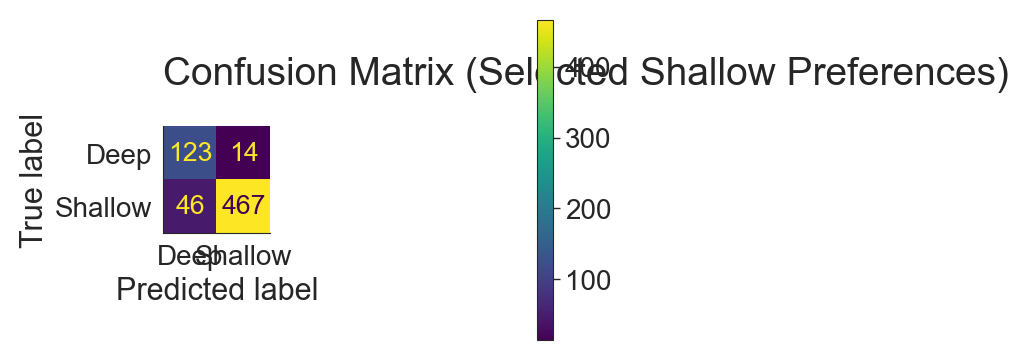

In [145]:

shallow_deep = df.query("set == 'shallow' & name in @past_mid or set == 'deep'")
filtered_shallow_deep = shallow_deep[shallow_deep['answer'] != 0]

y_true = (filtered_shallow_deep['set'] == 'shallow').astype(int)
y_pred = (filtered_shallow_deep['answer'] > 0).astype(int)

# Compute confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Deep', 'Shallow'])
cmd.plot()
plt.title('Confusion Matrix (Selected Shallow Preferences)')
plt.savefig('plots/confusion_matrix_filtered_selected.pdf', bbox_inches='tight', dpi=300)

print("\nClassification Report (Filtered):")
print(classification_report(y_true, y_pred, 
                            target_names=['Deep', 'Shallow'],
                            digits=3))


In [129]:
df['pid'].nunique()

41

In [130]:
df.groupby(by=['metric'])['pid'].nunique()

metric
deep_shallow    28
even            13
general         13
Name: pid, dtype: int64

In [132]:
13*20

260